<a href="https://colab.research.google.com/github/EricHeidbreder/data-centric-ai/blob/eric_h/data_centric_ai_comp_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:

import requests
import tarfile
import io
import numpy as np
from PIL import Image, ImageTk
from matplotlib import pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.preprocessing import dataset_utils
import os
import tensorflow as tf
from tensorflow import keras
import json
import sys
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

import shutil
import random

In [2]:
# Give you a fresh start on preprocessed data
shutil.rmtree('./data_preprocessed', ignore_errors=True)

# Building the preprocessing folder structure
os.mkdir('./data_preprocessed')
os.mkdir('./data_preprocessed/train')
os.mkdir('./data_preprocessed/val')
for num in ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']:
    os.mkdir(f'./data_preprocessed/train/{num}')
    os.mkdir(f'./data_preprocessed/val/{num}')

In [3]:
# get the test data into its own folder

test_path = './data_preprocessed/test'

tar_file = tarfile.open('./label_book.tar.gz')
tar_file.extractall(test_path)
tar_file.close()

orig_base_path = os.path.join(test_path, 'label_book')
for folder in os.listdir(orig_base_path):
    if folder != '.DS_Store':
        orig_path = os.path.join(orig_base_path, folder)
        new_path = test_path
        shutil.move(orig_path, new_path)

shutil.rmtree(orig_base_path)

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                   rotation_range=8,
                                   width_shift_range=0.08,
                                   height_shift_range=0.2,
                                   rescale=1/255,
                                   shear_range=0.3,
                                   zoom_range=0.08,
                                   horizontal_flip=False,
                                   vertical_flip=False)

# Best so far                                

# train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
#                                    rotation_range=5,
#                                    width_shift_range=0.05,
#                                    height_shift_range=0.2,
#                                    rescale=1/255,
#                                    shear_range=0,
#                                    zoom_range=0.05,
#                                    horizontal_flip=False,
#                                    vertical_flip=False)                                   

In [5]:
# batch_size = len(os.listdir('.\\data_sorted\\train\\ii'))

In [6]:
data_sorted_path = '.\\data_sorted_copy'
class_folders = os.listdir(data_sorted_path)

In [8]:
class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(data_sorted_path, 'train'),
    color_mode='grayscale',
    label_mode='int',
    class_names=class_names,
    seed=420,
    shuffle=True,
    image_size=(32,32)
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(data_sorted_path, 'val'),
    color_mode='grayscale',
    label_mode='int',
    class_names=class_names,
    seed=420,
    shuffle=True,
    image_size=(32,32)
)

Found 3427 files belonging to 10 classes.
Found 1193 files belonging to 10 classes.


In [9]:
class_names = train_ds.class_names

In [10]:
class_names

['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']

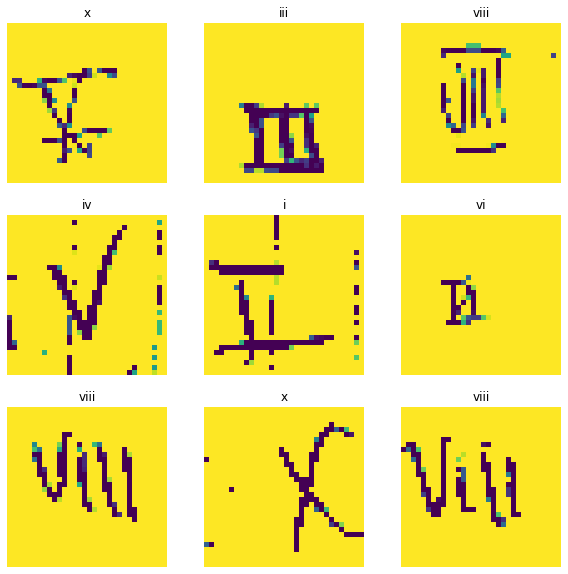

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
train_ds

108

In [53]:
x_train = pd.DataFrame([image.numpy().reshape(-1) for image_batch, label_batch in train_ds for image in image_batch])
x_val = pd.DataFrame([image.numpy().reshape(-1) for image_batch, label_batch in val_ds for image in image_batch])
y_train = pd.DataFrame([label for image_batch, label_batch in train_ds for label in label_batch])
y_val = pd.DataFrame([label for image_batch, label_batch in val_ds for label in label_batch])

In [193]:
NCOMPONENTS = 200

scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train)
x_val_sc = scaler.transform(x_val)

pca = PCA(n_components=NCOMPONENTS)
x_pca_train = pca.fit_transform(x_train_sc)
x_pca_val = pca.transform(x_val_sc)
pca_std = np.std(X_pca_train)

print(x_train_sc.shape)
print(X_pca_train.shape)

(3427, 1024)
(3427, 200)


In [194]:
inv_pca = pca.inverse_transform(X_pca_train)
inv_sc = scaler.inverse_transform(inv_pca)

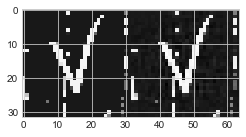

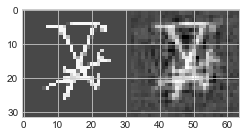

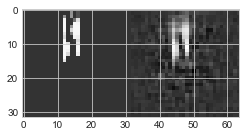

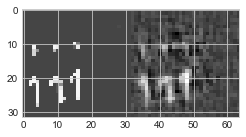

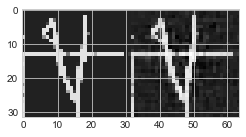

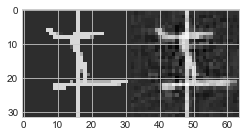

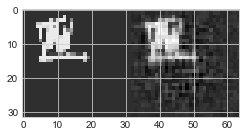

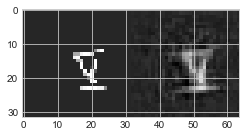

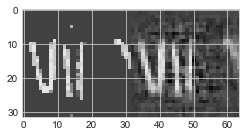

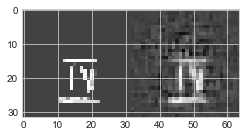

In [195]:
def side_by_side(indexes):
    org = x_train.iloc[indexes].to_numpy().reshape(32,32)
    rec = inv_sc[indexes].reshape(32,32)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)
    plt.show()
    
for index in range(0,10):
    side_by_side(index)



In [166]:
def threshold(x):
    if x > 80:
        return 0
    else:
        return 255

In [167]:
x_train_copy = x_train.copy().applymap(threshold)

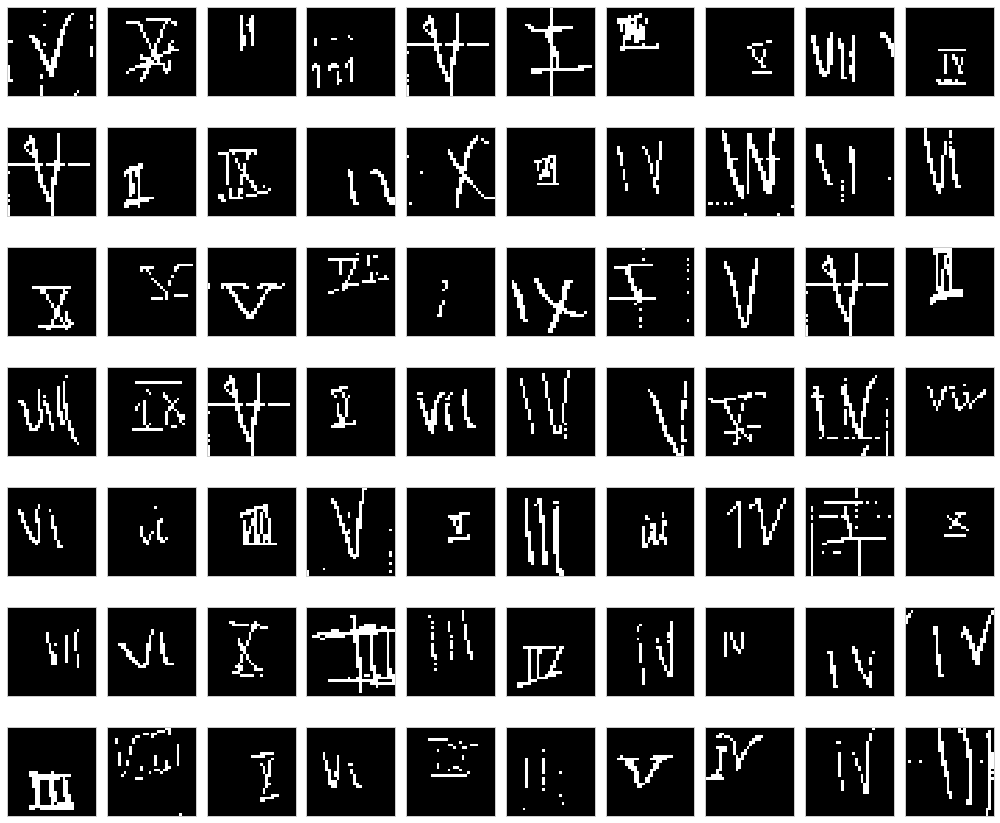

In [168]:
# plot some of the numbers
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = x_train_copy.iloc[digit_num].to_numpy().reshape(32, 32)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

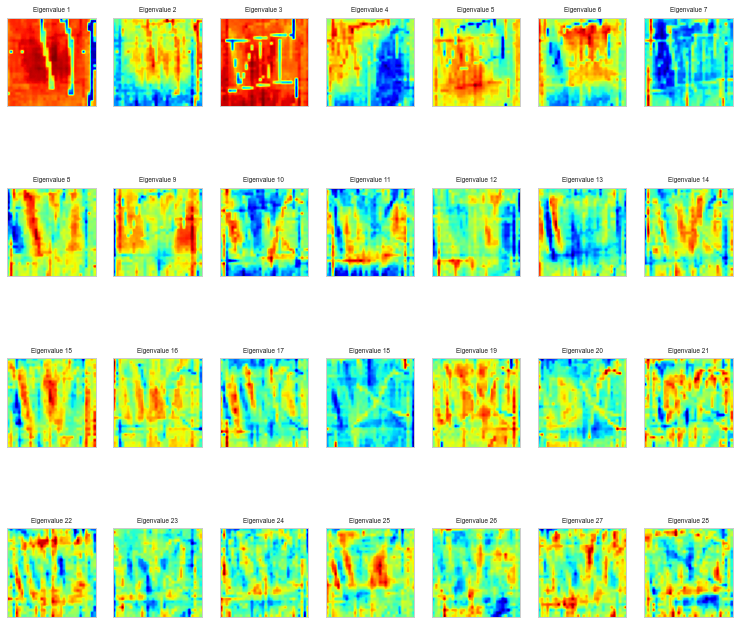

In [165]:




# Invoke SKlearn's PCA method
n_components = 30
pca = PCA(n_components=n_components).fit(x_train_sc)

eigenvalues = pca.components_.reshape(n_components, 32, 32)

# Extracting the PCA components ( eignevalues )
#eigenvalues = pca.components_.reshape(n_components, 28, 28)
eigenvalues = pca.components_

n_row = 4
n_col = 7

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(32,32), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

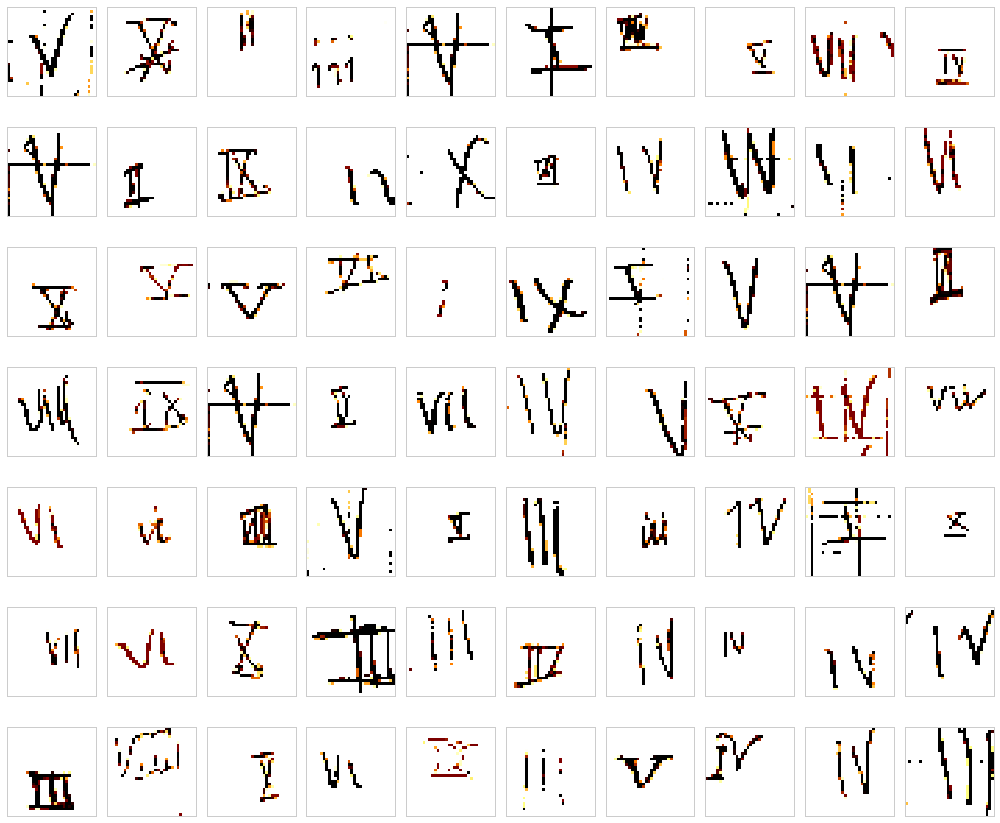

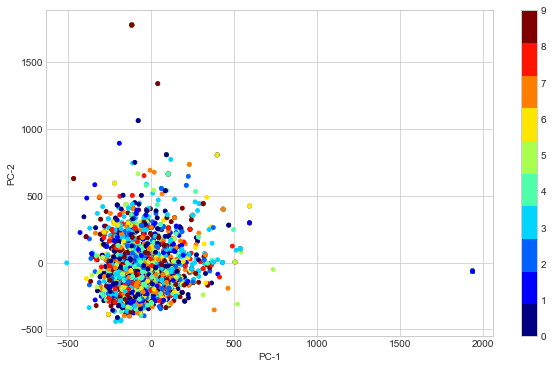

In [51]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = y_train_labels)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

In [80]:
y_train.to_numpy()

array([[0],
       [0],
       [2],
       ...,
       [1],
       [1],
       [7]])

In [203]:
# Taking only the first N rows to speed things up
X = x_train

# Standardising the values
X_std = StandardScaler().fit_transform(X)

# Call the PCA method with 5 components. 
pca = PCA(n_components=200)
pca.fit(X_std)
X_5d = pca.transform(X_std)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = y_train.to_numpy().reshape(-1)

lda = LDA(n_components=2)
# Taking in as second argument the Target as labels
X_LDA_2D = lda.fit_transform(X_std, Target)

In [204]:
8# Using the Plotly library again
traceLDA = go.Scatter(
    x = X_LDA_2D[:,0],
    y = X_LDA_2D[:,1],
#     name = Target,
#     hoveron = Target,
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceLDA]

layout = go.Layout(
    title= 'Linear Discriminant Analysis (LDA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Linear Discriminant',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Linear Discriminant',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [94]:
# Invoking the t-SNE method
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_std) 

In [96]:
traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    # name = Target,
    #  hoveron = Target,
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [182]:
# # Setting an equal amount of images per subclass

# for folder in class_folders:
#   # Don't do this in the test folder
#   if folder not in [
#     'test',
#     # 'train',
#     '.DS_Store',
#     # TODO: remove val after subgroups are added to that folder
#     # 'val'
#   ]:
#     class_folders = os.listdir(os.path.join(data_sorted_path, folder))
#   else:
#     continue

#   # Iterates through the subfolders in each class. 
#   # Makes sure there are an equal number of items from each subgroup within the classes by randomly sampling the smaller subgroups
#   for class_folder in class_folders:
    
#     # Gather initial information about the class path and the number of subgroups
#     if class_folder not in ['.DS_Store', 'junk_vals']:
#     # if class_folder == 'i':
#       class_path = os.path.join(data_sorted_path, folder, class_folder)
#       class_subgroups = os.listdir(class_path)
#       max_subgroup_len = 0

#       # Need to get the max number of files in a subgroup folder, so we can get them all to match later
#       for class_folder_subgroup in class_subgroups:
#         max_subgroup_len = max(len(os.listdir(os.path.join(data_sorted_path, folder, class_folder, class_folder_subgroup))), max_subgroup_len)

#       # Get the subgroup path (example i_lowercase, i_ruled, etc.)
#       for class_folder_subgroup in class_subgroups:
#         class_subgroup_path = os.path.join(data_sorted_path, folder, class_folder, class_folder_subgroup)

#         # If the subgroup isn't the max length, determine how many copies we need to make to get it to match
#         if len(os.listdir(class_subgroup_path)) < max_subgroup_len:
#           subgroup_images = os.listdir(class_subgroup_path)
#           num_subgroup_images = len(subgroup_images)
#           num_copies_to_make = max_subgroup_len - num_subgroup_images

#           # Make the copies using random sampling of the existing images
#           for i in range(num_copies_to_make):
#             random_image = subgroup_images[random.randint(0, num_subgroup_images - 1)]
#             shutil.copyfile(os.path.join(class_subgroup_path, random_image), class_subgroup_path+f'/copy_{i}_{random_image}')

#     else:
#         continue

In [183]:
class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
passes = 2
# batch_size = 10000/20

for class_name in class_names:
  base_path = './data_sorted_copy/train'
  class_path = os.path.join(base_path, class_name)
  total_len = 0
  for sub_folder in os.listdir(class_path):
    if not '.' in sub_folder:
      subclass_path = os.path.join(class_path, sub_folder)
      total_len += len(os.listdir(subclass_path))
    else:
      continue
  for _ in range(passes):
    train_generator = train_datagen.flow_from_directory(
      './data_sorted_copy/train',
      target_size=(32,32),
      batch_size=total_len,
      classes=[class_name],
      save_to_dir='./data_preprocessed/train/'+class_name,
      save_prefix='aug',
      shuffle=True
    )
    batch = next(train_generator)
 
for class_name in class_names:
  base_path = './data_sorted_copy/val'
  class_path = os.path.join(base_path, class_name)
  total_len = 0
  for sub_folder in os.listdir(class_path):
    if not '.' in sub_folder:
      subclass_path = os.path.join(class_path, sub_folder)
      total_len += len(os.listdir(subclass_path))
    else:
      continue
  # batch_size = len([f for f in os.listdir('./data_sorted_copy/val/'+ class_name) if os.path.isfile(os.path.join('./data_sorted_copy/val/' + class_name, f))])
  for _ in range(passes):
    validation_generator = train_datagen.flow_from_directory(
        './data_sorted_copy/val',
        target_size=(32, 32),
        class_mode='categorical',
        classes=[class_name],
        batch_size=total_len,
        shuffle=True,
        save_to_dir='./data_preprocessed/val/'+class_name,
        save_prefix='aug')  
    batch = next(validation_generator)

Found 513 images belonging to 1 classes.
Found 513 images belonging to 1 classes.
Found 270 images belonging to 1 classes.
Found 270 images belonging to 1 classes.
Found 258 images belonging to 1 classes.
Found 258 images belonging to 1 classes.
Found 549 images belonging to 1 classes.
Found 549 images belonging to 1 classes.
Found 339 images belonging to 1 classes.
Found 339 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 256 images belonging to 1 classes.
Found 256 images belonging to 1 classes.
Found 375 images belonging to 1 classes.
Found 375 images belonging to 1 classes.
Found 312 images belonging to 1 classes.
Found 312 images belonging to 1 classes.
Found 345 images belonging to 1 classes.
Found 345 images belonging to 1 classes.
Found 123 images belonging to 1 classes.
Found 123 images belonging to 1 classes.
Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.
Found 123 images b

In [184]:
directory = "./data_preprocessed"
user_data = directory + "/train"
valid_data = directory + "/val"
test_data = directory + "/test" # this can be the label book, or any other test set you create

### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
batch_size = 8
tf.random.set_seed(123)


if __name__ == "__main__":
    train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data,# + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    valid = tf.keras.preprocessing.image_dataset_from_directory(
        valid_data,# + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
    if total_length > 10_000:
        print(f"Dataset size larger than 10,000. Got {total_length} examples")
        sys.exit()

    test = tf.keras.preprocessing.image_dataset_from_directory(
        test_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=False,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    base_model = tf.keras.applications.ResNet50(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=None,
    )
    base_model = tf.keras.Model(
        base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
    )

    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.Model(inputs, x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    model.summary()
    loss_0, acc_0 = model.evaluate(valid)
    print(f"loss {loss_0}, acc {acc_0}")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train,
        validation_data=valid,
        epochs=100,
        callbacks=[checkpoint],
    )

    model.load_weights("best_model")

    loss, acc = model.evaluate(valid)
    print(f"final loss {loss}, final acc {acc}")

    test_loss, test_acc = model.evaluate(test)
    print(f"test loss {test_loss}, test acc {test_acc}")

   

Found 6854 files belonging to 10 classes.
Found 2386 files belonging to 10 classes.
Found 52 files belonging to 10 classes.
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 32, 32, 3)         0         
_________________________________________________________________
model_17 (Functional)        (None, 8, 8, 256)         229760    
_________________________________________________________________
global_average_pooling2d_8 ( (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      


In [185]:
roman_numeral_map = {
    'i': 0,
    'ii': 1,
    'iii': 2,
    'iv': 3,
    'v': 4,
    'vi': 5,
    'vii': 6,
    'viii': 7,
    'ix': 8,
    'x': 9
}

inverse_map = {value: key for key, value in roman_numeral_map.items()}

labels = model.predict(test)
label = [np.argmax(i) for i in labels]
class_labels = [inverse_map[x] for x in label]



In [186]:
pred_actuals_num = []

base_test_path = './data_preprocessed/test'
for class_name in os.listdir(base_test_path):
    for image in os.listdir(f'{base_test_path}/{class_name}'):
        if image != '.DS_Store':
            pred_actuals_num.append(roman_numeral_map[class_name])

pred_actuals_num.sort()
pred_actuals_roman = [inverse_map[number] for number in pred_actuals_num]

results_df = pd.DataFrame(list(zip(class_labels, pred_actuals_roman)), columns=['Predicted', 'Actual'])

In [187]:
correct = results_df[results_df['Predicted'] == results_df['Actual']]
incorrect = results_df[results_df['Predicted'] != results_df['Actual']]


Accuracy Score :  0.7115384615384616 



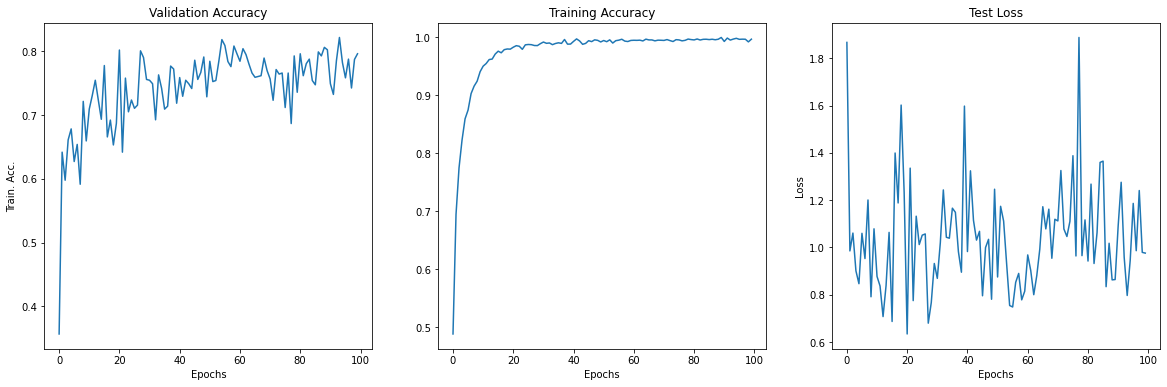

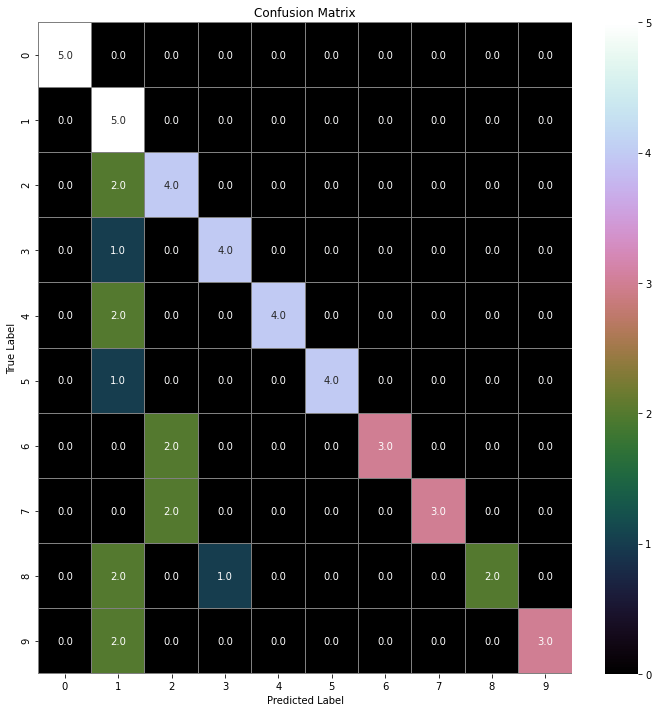

In [188]:
# evaluate the model
from sklearn import metrics
import seaborn as sns

Y_pred = model.predict(test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = pred_actuals_num
# Compute the confusion matrix

print("\n""Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()

confusion_mtx = metrics.confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="cubehelix",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()